# Plot Figure S3

This code plots an example visualization of the 2-D precipitation surface and the regimes described in the Supplemental Information (Figure S3).

## Import Necessary Packages

In [1]:
import warnings
import numpy as np
import xarray as xr
import proplot as pplt
from matplotlib.patches import Patch
pplt.rc['tick.minor']=False
warnings.filterwarnings('ignore')

## User-Defined Configurations

Specify the directory where the binned statistics datasets are, and set the directory where the figure will be saved. Select a region and month for which the example figure will be made, and set the minimum sample threshold for bin inclusion for statistical calculations.

In [2]:
FILEDIR       = '/global/cfs/cdirs/m4334/sferrett/monsoon-pod/data/processed'
SAVEDIR       = '/global/cfs/cdirs/m4334/sferrett/monsoon-pod/figs'
EXAMPLEREGION = 'Eastern Arabian Sea'
EXAMPLEMONTH  = 6
SAMPLETHRESH  = 50

## Load Example Binned Statistics Dataset

Load the HR-ERA5/IMERG dataset for our example visualization.

In [3]:
def load(filename,filedir=FILEDIR,varlist=None):
    filepath = f'{filedir}/{filename}'
    ds = xr.open_dataset(filepath)
    if varlist:
        ds = ds[varlist]
    return ds.load()

In [4]:
examplestats = load('HR_ERA5_IMERG_binned_stats.nc')

## Functions for Analysis and Plotting

Here, we use the `get_bin_mean_pr()` function to calculate the mean precipitation in each joint $\mathrm{SUBSAT_L}$-$\mathrm{CAPE_L}$ bin (for bins where the number of samples exceeds `SAMPLETHRESH`), as well as the `get_pdf()` and `get_mode()` functions to calculate the *precipitating* joint $\mathrm{SUBSAT_L}$-$\mathrm{CAPE_L}$ PDF and its mode.

In [5]:
def get_bin_mean_pr(monthstats,bintype,samplethresh=SAMPLETHRESH):
    if bintype=='1D':
        blbins = monthstats.bl.values
        Q0 = monthstats.Q0.values
        Q1 = monthstats.Q1.values
        Q0[Q0==0.0] = np.nan
        binmeanpr = Q1/Q0
        binmeanpr[Q0<samplethresh] = np.nan
        return xr.DataArray(binmeanpr,coords={'bl':blbins})
    if bintype=='2D':
        subsatbins = monthstats.subsat.values
        capebins   = monthstats.cape.values
        P0 = monthstats.P0.values
        P1 = monthstats.P1.values
        P0[P0==0.0] = np.nan
        binmeanpr = P1/P0
        binmeanpr[P0<samplethresh] = np.nan
        return xr.DataArray(binmeanpr,coords={'subsat':subsatbins,'cape':capebins})

def get_pdf(monthstats,bintype,precipitating=False):
    if bintype=='1D':
        blbins = monthstats.bl.values
        Q0 = monthstats.Q0.values
        QE = monthstats.QE.values
        Q  = QE if precipitating else Q0
        norm = np.nansum(Q0)*np.diff(blbins)[0]
        pdf  = Q/norm
        return xr.DataArray(pdf,coords={'bl':blbins})
    if bintype=='2D':
        subsatbins = monthstats.subsat.values
        capebins   = monthstats.cape.values
        P0 = monthstats.P0.values
        PE = monthstats.PE.values
        P  = PE if precipitating else P0
        norm = np.nansum(P0)*np.diff(subsatbins)[0]*np.diff(capebins)[0]
        pdf  = P/norm
        return xr.DataArray(pdf,coords={'subsat':subsatbins,'cape':capebins})

def get_mode(pdf,bintype):
    if bintype not in ['1D','2D']:
        raise ValueError("Bin type must be '1D' or '2D'")   
    if bintype=='1D':
        blbins   = pdf.bl.values
        maxblidx = np.nanargmax(pdf.values)
        return blbins[maxblidx]
    if bintype=='2D':
        subsatbins = pdf.subsat.values
        capebins   = pdf.cape.values
        maxsubsatidx,maxcapeidx = np.unravel_index(np.nanargmax(pdf.values),pdf.values.shape)
        return subsatbins[maxsubsatidx],capebins[maxcapeidx]

The `get_sensitivity_metrics()` function divides the 2-D precipitation surface into three precipitation "regimes" based on the location of the precipitating joint $\mathrm{SUBSAT_L}$-$\mathrm{CAPE_L}$ PDF mode. In this case, we return the masks for each regime.

In [6]:
def get_sensitivity_metrics(binmeanpr,jointpdf,prsurfaces=False,ratios=False,polar=False):
    subsatmode,capemode = get_mode(jointpdf,'2D')
    validmode = False
    for i in range(binmeanpr.subsat.size):
        if not np.isnan(binmeanpr.sel(subsat=subsatmode,cape=capemode,method='nearest')):
            validmode = True
            break
        subsatmode += binmeanpr.subsat[1]-binmeanpr.subsat[0]
    if not validmode:
        raise ValueError('Could not locate valid point for precipitation sensitivity computation.')
    binmeanpra = ~np.isnan(binmeanpr)&(binmeanpr.subsat<=subsatmode)&(binmeanpr.cape>=capemode)
    binmeanprb = ~np.isnan(binmeanpr)&(binmeanpr.subsat<=subsatmode)&(binmeanpr.cape<=capemode)
    binmeanprc = ~np.isnan(binmeanpr)&(binmeanpr.subsat>=subsatmode)&(binmeanpr.cape>=capemode)
    nomask     = ~np.isnan(binmeanpr)&~(binmeanpra|binmeanprb|binmeanprc)
    if prsurfaces==True:
        return binmeanpra,binmeanprb,binmeanprc,nomask
    subsata = binmeanpr.subsat.where(binmeanpra).mean().values
    subsatc = binmeanpr.subsat.where(binmeanprc).mean().values
    capea = binmeanpr.cape.where(binmeanpra).mean().values
    capeb = binmeanpr.cape.where(binmeanprb).mean().values
    pra = binmeanpr.where(binmeanpra).mean().values
    prb = binmeanpr.where(binmeanprb).mean().values
    prc = binmeanpr.where(binmeanprc).mean().values
    capesensitivity   = abs(pra-prb)/abs(capea-capeb)
    subsatsensitivity = abs(pra-prc)/abs(subsata-subsatc)
    if ratios==True:
        return capesensitivity,subsatsensitivity
    gammamag = np.sqrt(capesensitivity**2+subsatsensitivity**2)
    theta    = np.arctan(capesensitivity/subsatsensitivity)
    if polar:
        return gammamag,theta

The `create_si_plot()` function generates a formatted figure that plots the example results for the Supplemental Information.

In [7]:
def create_si_plot(examplestats,exampleregion=EXAMPLEREGION,examplemonth=EXAMPLEMONTH,samplethresh=SAMPLETHRESH,filename=None):
    monthstats = examplestats.sel(region=exampleregion,month=examplemonth)
    binmeanpr  = get_bin_mean_pr(monthstats,'2D',samplethresh)
    jointpdf   = get_pdf(monthstats,'2D',precipitating=True)
    subsatmode,capemode      = get_mode(jointpdf,'2D')
    maska,maskb,maskc,nomask = get_sensitivity_metrics(binmeanpr,jointpdf,prsurfaces=True)
    fig,axs = pplt.subplots(nrows=1,ncols=2,refwidth=2)
    axs.format(facecolor='gray1',xlabel='$SUBSAT_L$ (K)',xlim=(0,30),xticks=5,xminorticks='none',
               ylabel='$CAPE_L$ (K)',ylim=(-20,10),yticks=5,yminorticks='none')
    cmap = axs[0].pcolormesh(binmeanpr.T,cmap='ColdHot_r',cmap_kw={'left':0.5},vmin=0,vmax=100,levels=11,extend='max')
    mode = axs[0].scatter(subsatmode,capemode,color='k',marker='*',s=150,label=f'Precipitating\nPDF Mode')
    axs[0].colorbar(cmap,loc='r',label='Precipitation (mm/day)')
    maskdict = [(maska,'#D42028','Regime A'),(maskb,'#F2C85E','Regime B'),(maskc,'#5BA7DA','Regime C'),(nomask,'gray','No Regime')]
    for mask,color,label in maskdict:
        axs[1].pcolormesh(binmeanpr.subsat,binmeanpr.cape,np.where(mask.T,1,np.nan),color=color,alpha=0.6)        
    axs[1].scatter(subsatmode,capemode,color='k',marker='*',s=150,label=f'Precipitating\nPDF Mode')
    handles = [Patch(facecolor=color,label=label,alpha=0.6) for _,color,label in maskdict]+[mode]
    axs[1].legend(handles=handles,loc='r',ncols=1)
    pplt.show()
    if filename:
        fig.save(f'{SAVEDIR}/{filename}',dpi=900)

## Plot and Save Figure

Execute plotting, and save the figure to `SAVEDIR`.

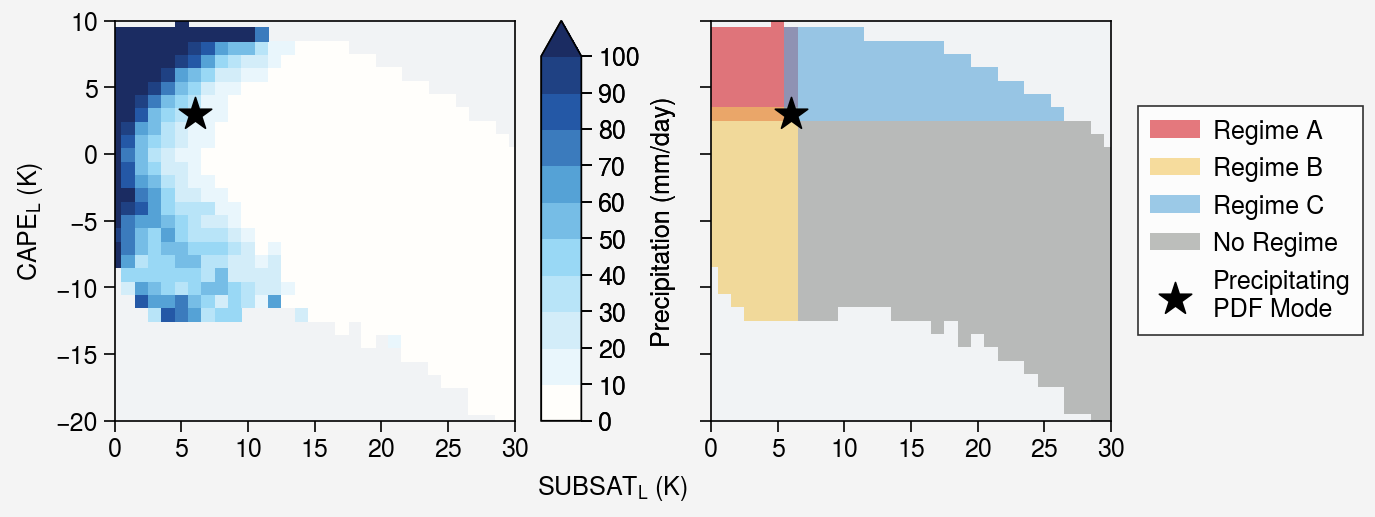

In [8]:
create_si_plot(examplestats,filename='fig_S3.jpg')